<ipython-input-25-73483eb9168a>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1, -1)


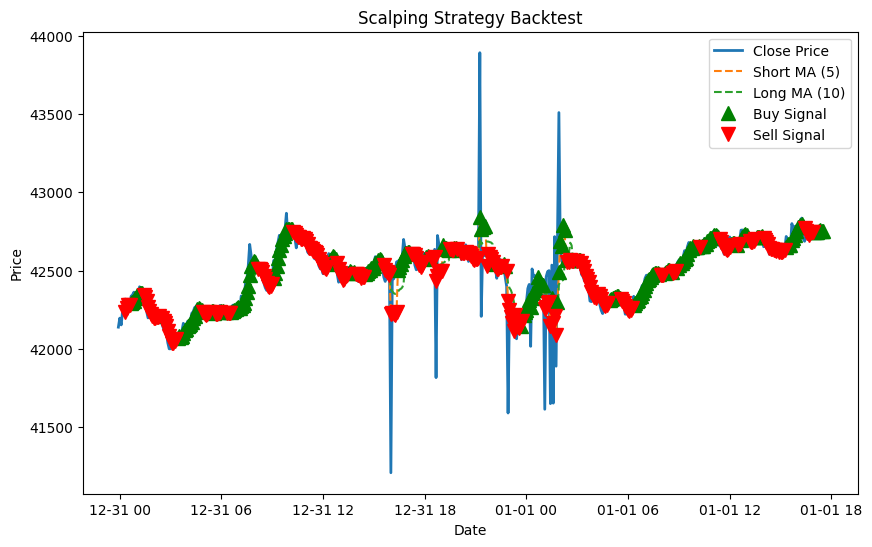

Initial Balance: 10000
Final Balance: 10109.34893759966
Cumulative Returns: 0.010934893759966036


In [25]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Binance API credentials
api_key = '0e94f8bfa93f5e4d0c3e64d4a8ab2bbf4ce891b80cc87f0f7baaf3aa7b34c445'
api_secret = '39ead8ebdd0ba4c88cd56d467f5274feaf82cd3994621309657b1978f096da16'
client = Client(api_key, api_secret, tld="futures", testnet=True)

# Symbol and time interval
symbol = 'BTCUSDT'
interval = '5m'  # 1 minute candles

# Download historical data
klines = client.get_klines(symbol=symbol, interval=interval)

# Extract relevant data and create a DataFrame
data = {
    'timestamp': [entry[0] for entry in klines],
    'open': [float(entry[1]) for entry in klines],
    'high': [float(entry[2]) for entry in klines],
    'low': [float(entry[3]) for entry in klines],
    'close': [float(entry[4]) for entry in klines],
}

df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Scalping strategy parameters
short_window = 5
long_window = 10

# Create signals
df['short_ma'] = df['close'].rolling(window=short_window).mean()
df['long_ma'] = df['close'].rolling(window=long_window).mean()

df['signal'] = 0  # 0: Hold, 1: Buy, -1: Sell
df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1, -1)

# Calculate returns
df['returns'] = df['close'].pct_change() * df['signal'].shift(-1)

# Handle division by zero
df['returns'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['returns'].fillna(0, inplace=True)

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# Initial balance
initial_balance = 10000  # Set your initial balance here
df['balance'] = initial_balance * (1 + df['returns']).cumprod()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='Close Price', linewidth=2)
plt.plot(df.index, df['short_ma'], label=f'Short MA ({short_window})', linestyle='--')
plt.plot(df.index, df['long_ma'], label=f'Long MA ({long_window})', linestyle='--')

# Plot buy signals
plt.plot(df[df['signal'] == 1].index, df['short_ma'][df['signal'] == 1], '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
plt.plot(df[df['signal'] == -1].index, df['short_ma'][df['signal'] == -1], 'v', markersize=10, color='r', label='Sell Signal')

plt.title('Scalping Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print final results
final_balance = df['balance'].iloc[-1]
print("Initial Balance:", initial_balance)
print("Final Balance:", final_balance)
print("Cumulative Returns:", final_balance / initial_balance - 1)


In [8]:
!pip install python-binance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00
